In [1]:
## Enable matplotlib inline
%matplotlib inline

## Imports
import pandas as pd
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 

import numpy as np

In [2]:
## Load training dataset
train = pd.read_csv('train.csv')

In [3]:
train

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
1,1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
2,1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
3,1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
4,1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
5,1,55,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254000
6,2,1,2,9.0,5.0,7.5,10.5,15.0,10.5,16.5,23.5,0.998333,0.998333,0.998333,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016000
7,2,6,2,26.5,22.5,25.5,31.5,26.5,26.5,28.5,32.0,1.001667,0.981667,0.998333,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016000
8,2,11,2,21.5,15.5,20.5,25.0,26.5,23.5,25.0,27.0,1.001667,0.995000,0.998333,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016000
9,2,16,2,18.0,14.0,17.5,21.0,20.5,18.0,20.5,23.0,0.995000,0.995000,0.998333,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016000


,radardist_km,minutes_past,Expected
63,13,3,0.508
64,13,7,0.508
65,13,11,0.508
66,13,15,0.508
67,13,19,0.508
68,13,23,0.508
69,13,27,0.508
70,13,31,0.508
71,13,35,0.508
72,13,39,0.508


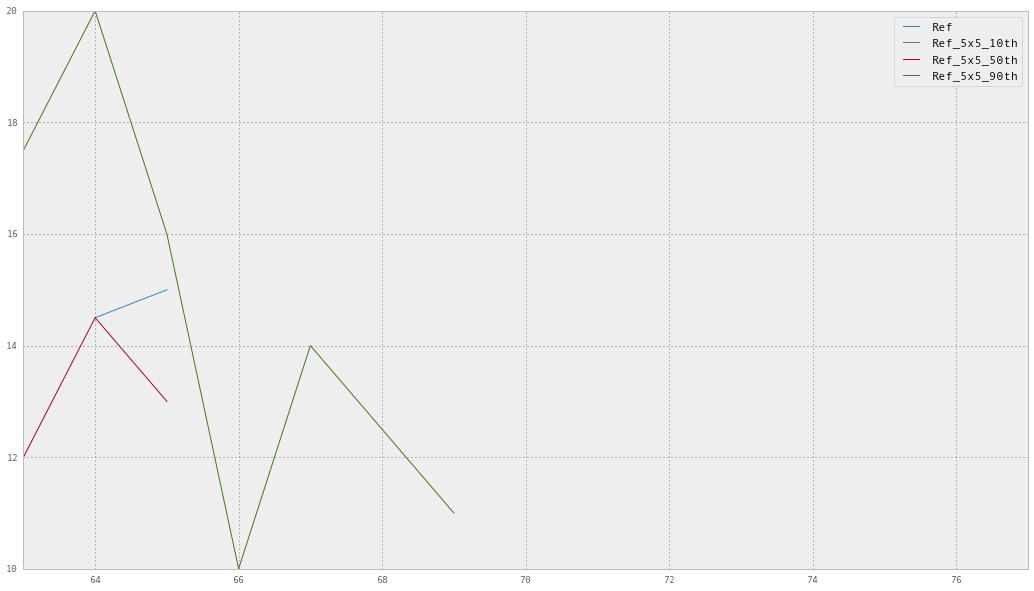

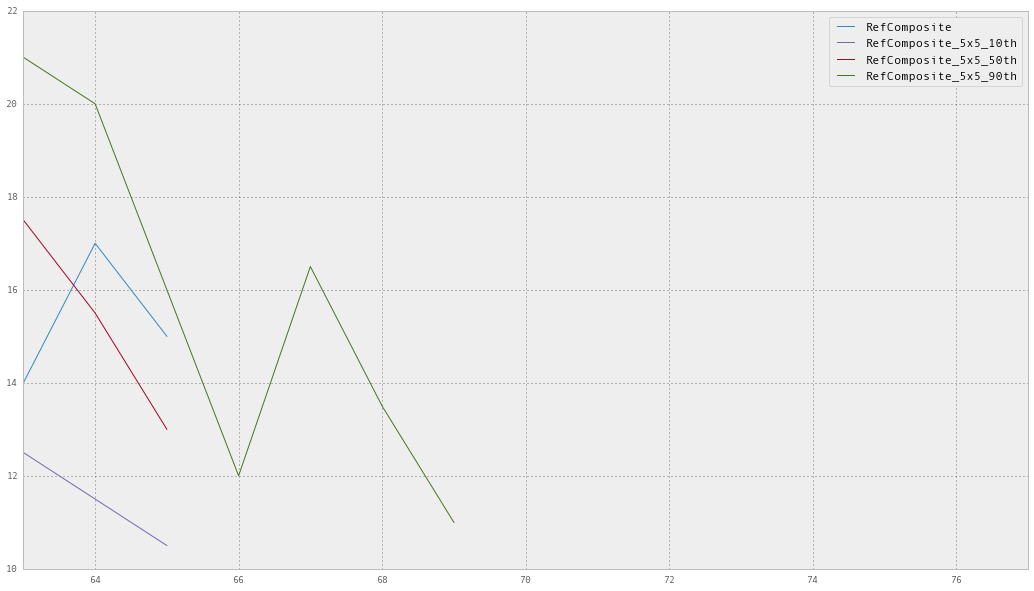

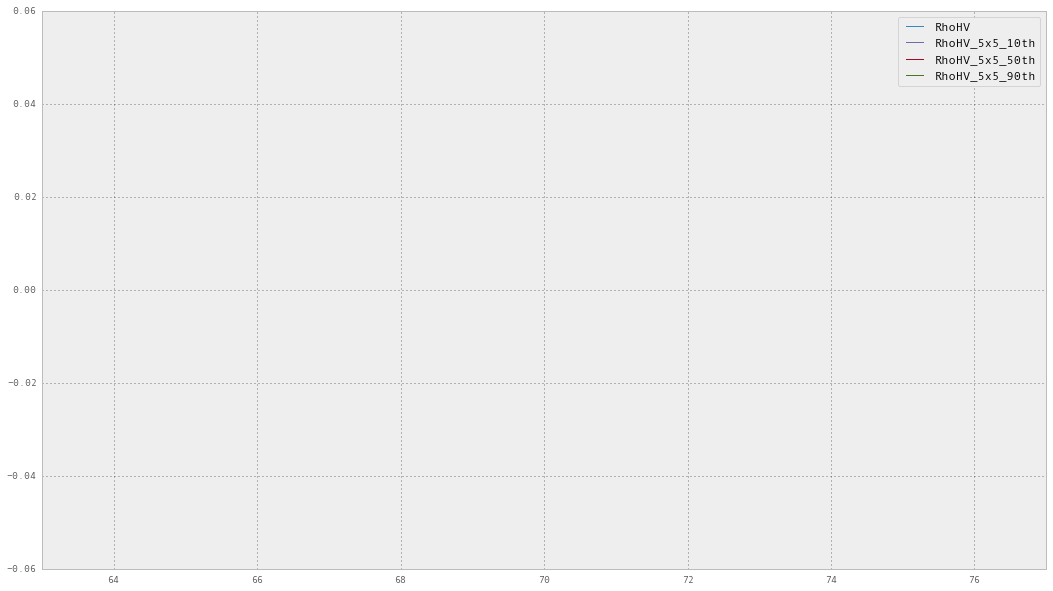

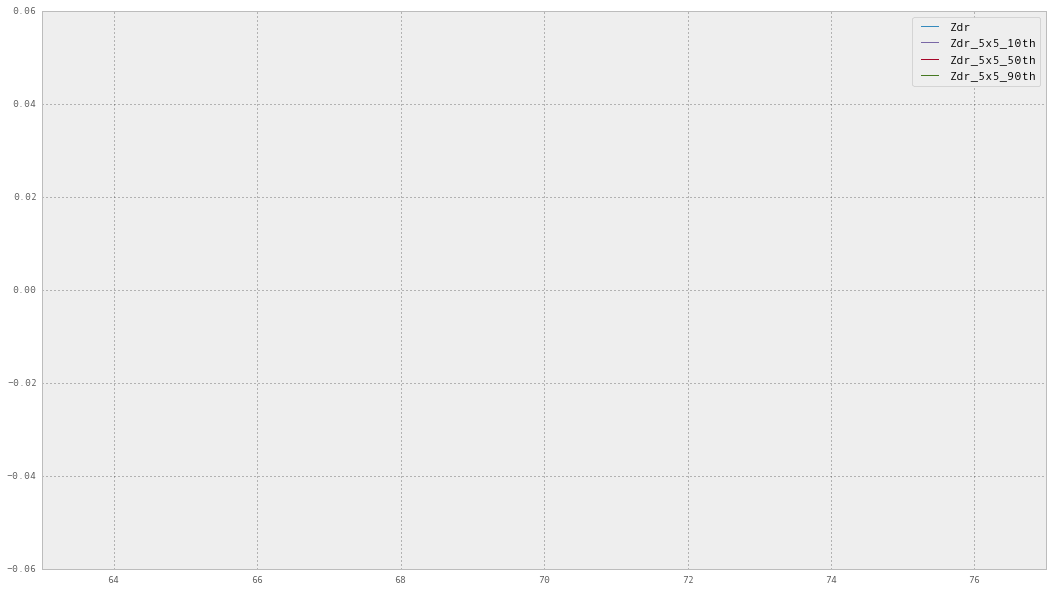

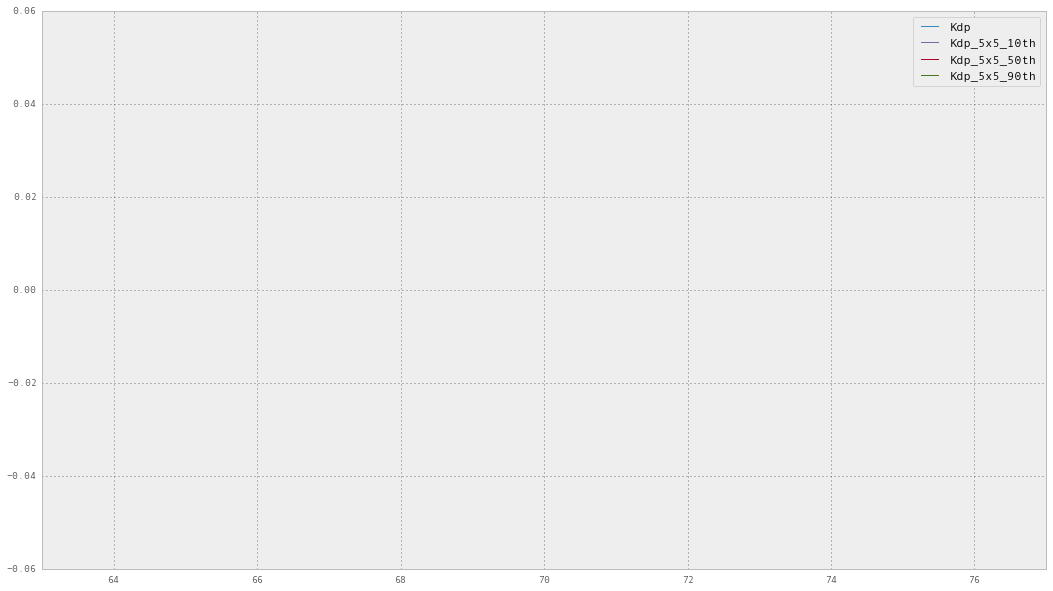

In [4]:
id = 7
train[['Ref', 'Ref_5x5_10th', 'Ref_5x5_50th', 'Ref_5x5_90th']][train['Id'] == id].plot(figsize=(18,10))
train[['RefComposite', 'RefComposite_5x5_10th', 'RefComposite_5x5_50th', 'RefComposite_5x5_90th']][train['Id'] == id].plot(figsize=(18,10))
train[['RhoHV', 'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th']][train['Id'] == id].plot(figsize=(18,10))
train[['Zdr', 'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th']][train['Id'] == id].plot(figsize=(18,10))
train[['Kdp', 'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th']][train['Id'] == id].plot(figsize=(18,10))
train[['radardist_km', 'minutes_past', 'Expected']][train['Id'] == id]

In [5]:
from scipy import interpolate
from scipy import integrate
from matplotlib import pyplot as plt
import numpy as np

In [6]:
## =====================================
class RadarSeries:
    """
    A class to keep and process a single radar one-hour time series
    """
    
    ## -------------------------------------
    def __init__(self, dataset, Id):
        """
        Constructor: extract time series with identifier 'Id'
                    out of dataset 'dataset'
        """
        
        self.dataset = dataset[dataset['Id'] == Id]
        
        ## Extract the time values
        self.time = self.dataset['minutes_past'].values
        
        ## Extract constant values
        self.id           = Id
        self.radardist_km = self.dataset['radardist_km'].values[0]
        
        ## Training dataset has expected rain gauge values
        try:
            self.rain = self.dataset['Expected'].values[0]
            
        ## Testing dataset doesn't
        except:
            self.rain = None
    
    
    ## -------------------------------------
    def plot_quantity(self, quantity):
        """
        plots a single quantity
        """
        
        value  = self.dataset[quantity].values
        median = self.dataset[quantity + '_5x5_50th'].values
        low    = self.dataset[quantity + '_5x5_10th'].values
        high   = self.dataset[quantity + '_5x5_90th'].values
        
        plt.plot(self.time, value, 'k', color='#000000', linewidth=2)
        plt.plot(self.time, median, 'k', color='#1111BB')
        plt.fill_between(self.time, low, high, alpha=0.2, edgecolor='#1111BB', facecolor='#1111BB', linewidth=0)
        plt.show()
        
        
    ## --------------------------------------
    def naive_integration(self, quantity):
        """
        do an interpolation for the full hour and integrate
        """
        
        ## Remove NaN values for the quantity
        clean_dataset = self.dataset[~self.dataset[quantity].isnull()]
        
        ## Default value if all NaNs
        if len(clean_dataset) == 0: return -1111
        
        if len(clean_dataset) == 1:
            return clean_dataset[quantity].values[0]*60.0
        
        #if len(clean_dataset) < 4:
        avg = np.average(clean_dataset[quantity].values)
        return avg*60.0
        
#         ## Extract the numpy arrays for interpolation
#         clean_time = clean_dataset['minutes_past'].values
#         clean_quantity = clean_dataset[quantity].values
        
#         ## Calculate the interpolation while filling a default value
#         interpolation = interpolate.interp1d(
#             clean_time, 
#             clean_quantity, 
#             kind='linear',
#             bounds_error=False,
#             fill_value=np.average(clean_quantity)
#         )
        
#         ## return the integrated value over the time series
#         return integrate.quad(interpolation, 0, 60)[0]
    
    
    ## --------------------------------------
    def naive_average(self, quantity):
        """
        do an average of the available values during the hour
        """
        
        ## Remove NaN values for the quantity
        clean_dataset = self.dataset[~self.dataset[quantity].isnull()]
        
        ## Default value if all NaNs
        if len(clean_dataset) == 0: return -1111
        
        return np.average(clean_dataset[quantity].values)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


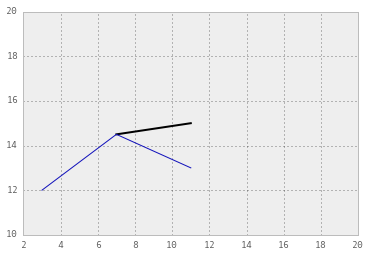

Integrated Ref : 885.0
Integrated RefComposite : 885.0
Average RhoHV : -1111
Average Zdr : -1111
Average Kdp : -1111


In [7]:
r = RadarSeries(train,7)
r.plot_quantity('Ref')
print 'Integrated Ref :', r.naive_integration('Ref')
print 'Integrated RefComposite :', r.naive_integration('RefComposite')
print 'Average RhoHV :', r.naive_average('RhoHV')
print 'Average Zdr :', r.naive_average('Zdr')
print 'Average Kdp :', r.naive_average('Kdp')

## Now that I can intelligently boil down a radar time series to a single ntuple, process the entire training dataset

In [8]:
import time

## Total number of separate readings
n = train.Id.nunique()

## Prepare training array
training_list = []

t = time.time()

## Ids start counting at 1
for i in range(1, n+1):
    
    if i%1000 == 0:
        print i, time.time() - t
        t = time.time()
    
    r = RadarSeries(train, i)
    
    datum = [
        r.radardist_km,
        r.naive_integration('Ref'),
        r.naive_integration('RefComposite'),
        r.naive_average('RhoHV'),
        r.naive_average('Zdr'),
        r.naive_average('Kdp'),
        r.rain
    ]
    
    training_list.append(datum)
    

1000 14.0058829784
2000 13.8952829838
3000 14.0504369736
4000 14.0171618462
5000 14.1746759415
6000 14.2099919319
7000 14.1983039379
8000 14.2221019268
9000 14.302932024
10000 15.6486182213
11000 14.7826981544
12000 15.6309227943
13000 15.3661839962
14000 14.176101923
15000 14.8837599754
16000 14.2017588615
17000 14.0474939346
18000 14.0694739819
19000 14.1760179996
20000 13.9772379398
21000 13.9156930447
22000 13.9919278622
23000 14.0723948479
24000 14.0374860764
25000 13.7497820854
26000 13.4588968754
27000 13.9618310928
28000 13.9785671234
29000 15.0077161789
30000 14.4790689945
31000 13.9680690765
32000 13.91020298
33000 14.0762488842
34000 13.8397209644
35000 13.8436160088
36000 13.9360609055
37000 13.917555809
38000 13.9600498676
39000 16.5908911228
40000 18.6122558117
41000 22.7943930626
42000 25.6535179615
43000 22.0993320942
44000 22.2856469154
45000 16.3797860146
46000 14.3767440319
47000 15.5797410011
48000 16.0179378986
49000 14.210914135
50000 15.1724851131
51000 14.143944

In [9]:
training_list

[[10.0, -1111, -1111, -1111, -1111, -1111, 0.25400012999999999],
 [2.0,
  997.5,
  1360.0,
  0.99861111416666659,
  0.38020833333333331,
  -0.28818720727272729,
  1.0160004999999999],
 [10.0, -1111, -1111, -1111, -1111, -1111, 26.162014000000003],
 [9.0,
  1596.0,
  1600.0,
  0.98833333999999995,
  -1.125,
  7.0299990000000001,
  4.0640019999999994],
 [13.0, -1111, -1111, -1111, -1111, -1111, 774.70044000000007],
 [13.0, -1111, -1111, -1111, -1111, -1111, 0.25400012999999999],
 [13.0, 885.0, 885.0, -1111, -1111, -1111, 0.50800025000000004],
 [8.0,
  1176.0,
  1475.4545454545455,
  0.931666675,
  1.15625,
  0.0024986499999999356,
  3.2250017999999998],
 [18.0, -1111, -1111, -1111, -1111, -1111, 18.28801],
 [10.0,
  2037.5000000000002,
  2087.5,
  0.90277777833333328,
  0.25520833333333331,
  -1.4041722916666668,
  0.010000004999999999],
 [12.0,
  1157.1428571428571,
  1157.1428571428571,
  0.98547620571428574,
  0.48214285714285715,
  -1.4500035057142857,
  2.5400014],
 [6.0,
  1971.0,


In [10]:
training_array = np.array(training_list)

In [11]:
target = training_array[:,6]
data   = training_array[:,0:6]

In [12]:
## Import scikit-learn stuff
from sklearn import ensemble
regressor = ensemble.GradientBoostingRegressor()
regressor.fit(data, target)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [13]:
## obtain testing dataset
test = pd.read_csv('test.csv')

In [14]:
## Total number of separate readings
n = test.Id.nunique()
testing_list = []

In [15]:
## Ids start counting at 1
for i in range(1, n+1):
    
    if i%1000 == 0:
        print i, time.time() - t
        t = time.time()
    
    r = RadarSeries(test, i)
    
    datum = (
        r.radardist_km,
        r.naive_integration('Ref'),
        r.naive_integration('RefComposite'),
        r.naive_average('RhoHV'),
        r.naive_average('Zdr'),
        r.naive_average('Kdp'),
        r.rain
    )
    
    testing_list.append(datum)

1000 97.9639360905
2000 7.92805600166
3000 7.7689268589
4000 7.88390803337
5000 7.86199998856
6000 7.89617395401
7000 7.78118515015
8000 7.82276415825
9000 7.86291217804
10000 7.87453007698
11000 7.76500892639
12000 7.80769205093
13000 7.78945302963
14000 7.87121510506
15000 7.90298390388
16000 7.77591991425
17000 7.91046094894
18000 7.71745204926
19000 7.81232905388
20000 7.89651203156
21000 7.82717394829
22000 7.76101779938
23000 7.99010109901
24000 7.89275383949
25000 7.88294386864
26000 7.87207198143
27000 7.86525607109
28000 7.86225605011
29000 7.85286998749
30000 7.82617092133
31000 7.91953086853
32000 7.80759906769
33000 7.88533520699
34000 7.88367009163
35000 7.83234596252
36000 7.80111694336
37000 7.87203598022
38000 7.8076210022
39000 7.87247395515
40000 7.87928414345
41000 7.83333516121
42000 7.78667402267
43000 7.94083189964
44000 7.93611907959
45000 7.84731292725
46000 7.93066000938
47000 7.86072897911
48000 7.90255308151
49000 7.85172200203
50000 7.98665499687
51000 7.813

In [16]:
testing_dataframe = pd.DataFrame(testing_list, columns=['radardist_km', 'Ref', 'RefComposite', 'RhoHV', 'Zdr', 'Kdp', 'Expected'])

In [17]:
testing_dataframe

,radardist_km,Ref,RefComposite,RhoHV,Zdr,Kdp,Expected
0,8,630.000000,682.500000,1.011667,-0.546875,-1.523336,NaN
1,15,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,NaN
2,11,1423.333333,1503.333333,0.927333,0.418750,0.219994,NaN
3,9,1848.750000,1920.000000,0.967667,0.100000,0.911996,NaN
4,17,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,NaN
5,13,930.000000,981.428571,0.975000,0.718750,5.494995,NaN
6,9,1759.090909,1761.818182,0.972037,0.076389,-0.221254,NaN
7,15,1268.571429,1467.857143,0.900000,3.343750,-1111.000000,NaN
8,15,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,NaN
9,11,1755.000000,1850.000000,1.002222,0.187500,0.000000,NaN


In [18]:
def predict(radardist_km, Ref, RefComposite, RhoHV, Zdr, Kdp):
    return regressor.predict([radardist_km, Ref, RefComposite, RhoHV, Zdr, Kdp])[0]

In [19]:
testing_dataframe['Expected'] = map(
    predict,
    testing_dataframe['radardist_km'],
    testing_dataframe['Ref'],
    testing_dataframe['RefComposite'],
    testing_dataframe['RhoHV'],
    testing_dataframe['Zdr'],
    testing_dataframe['Kdp']
)

In [20]:
def increment(index):
    return index + 1
testing_dataframe['Id'] = map(increment, testing_dataframe.index)

In [21]:
testing_dataframe

,radardist_km,Ref,RefComposite,RhoHV,Zdr,Kdp,Expected,Id
0,8,630.000000,682.500000,1.011667,-0.546875,-1.523336,-13.296947,1
1,15,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,905.132726,2
2,11,1423.333333,1503.333333,0.927333,0.418750,0.219994,23.550789,3
3,9,1848.750000,1920.000000,0.967667,0.100000,0.911996,25.321804,4
4,17,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,211.133583,5
5,13,930.000000,981.428571,0.975000,0.718750,5.494995,24.446656,6
6,9,1759.090909,1761.818182,0.972037,0.076389,-0.221254,25.321804,7
7,15,1268.571429,1467.857143,0.900000,3.343750,-1111.000000,103.789759,8
8,15,-1111.000000,-1111.000000,-1111.000000,-1111.000000,-1111.000000,905.132726,9
9,11,1755.000000,1850.000000,1.002222,0.187500,0.000000,23.600304,10


In [22]:
testing_dataframe[['Id', 'Expected']].to_csv('predictions2.csv', index=False)